# Introduction: Taxi Fare Prediction

Welcome to another Kaggle challenge. In this contest, the aim is to predict the fare of a taxi ride given the starting time, the starting and ending latitude / longitude, and the number of passengers. This is a __supervised regression__ machine learning task.

In this notebook, I'll provide you with a solid foundation and leave you with the challenge to better the score. Although the dataset is large, this is an approachable problem and as usual with Kaggle competitions, provides realistic practice for building a machine learning solution.

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set random seed 
RSEED = 100

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

import seaborn as sns

## Read in 5 million rows and examine data

Throughout this notebook, we will work with only 5 million rows (out of 55 million). The first point for improvement might therefore be to use more data!

* __Potential improvement 1: use more data__

First we'll remove any `nan` (observations with missing entries). We will also drop the `key` since it is a unique identifier and does not tell us anything about the taxi trip.

In [2]:
data = pd.read_csv('input/train.csv', nrows = 5_000_000, 
                   parse_dates = ['pickup_datetime']).drop(columns = 'key')

# Remove na
data = data.dropna()
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.500,2009-06-15 17:26:21,-73.844,40.721,-73.842,40.712,1
1,16.900,2010-01-05 16:52:16,-74.016,40.711,-73.979,40.782,1
2,5.700,2011-08-18 00:35:00,-73.983,40.761,-73.991,40.751,2
3,7.700,2012-04-21 04:30:42,-73.987,40.733,-73.992,40.758,1
4,5.300,2010-03-09 07:51:00,-73.968,40.768,-73.957,40.784,1


### Describe Data

An effective method for catching outliers and anomalies is to find the summary statistics for the data using the `.describe()` method. I like to concentrate on the maxes and the minimums.

In [3]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4999964.000,4999964.000,4999964.000,4999964.000,4999964.000,4999964.000
mean,11.341,-72.507,39.920,-72.507,39.917,1.685
std,9.820,12.810,8.963,12.848,9.487,1.332
min,-100.000,-3426.609,-3488.080,-3412.653,-3488.080,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.964,40.768,2.000
max,1273.310,3439.426,3310.364,3457.622,3345.917,208.000


Right away we can see there are a number of outliers in the `latitude` and `longitude` columns as well as at least one suspicious entry in the `passenger_count`. The target varible, `fare_amount` seems to have both negative values (unexpected) and extreme values (not so unexpected).

### Examine the Target Variable

For a first graphical exploration, we can look at the distribution of the `fare_amount`, the target variable we want to train a model to predict.

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


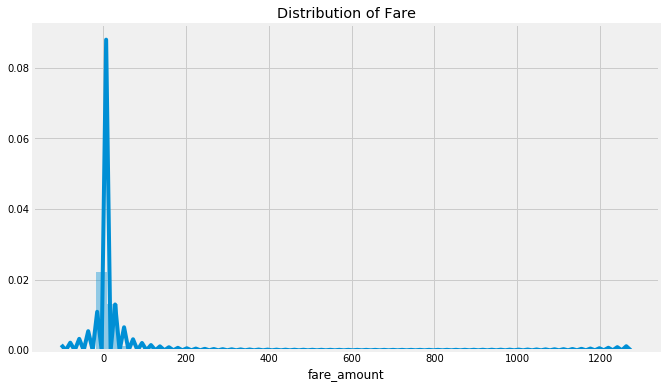

In [4]:
plt.figure(figsize = (10, 6))
sns.distplot(data['fare_amount']);
plt.title('Distribution of Fare');

In [5]:
print(f"There are {len(data[data['fare_amount'] < 0])} negative fares.")
print(f"There are {len(data[data['fare_amount'] == 0])} $0 fares.")
print(f"There are {len(data[data['fare_amount'] > 100])} fares greater than $100.")

There are 211 negative fares.
There are 132 $0 fares.
There are 1977 fares greater than $100.


### Remove Outliers

I'm going to remove any fares less than or equal to \$0 and also any fares greater than \$100. I'll justify this based on the limited number of fares outside these bounds, but it might be possible that including these values helps the model! I'd encourage you to try different values and see which works best.

In [6]:
data = data[data['fare_amount'].between(left = 0, right = 100)]

For visualization purposes, I'll create a binned version of the fare. 

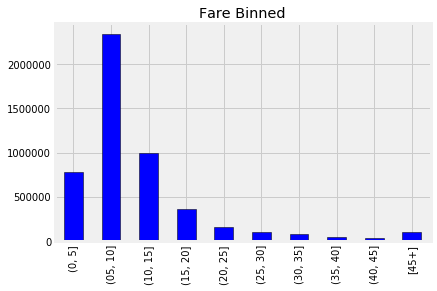

In [7]:
# Bin the fare and convert to string
data['fare-bin'] = pd.cut(data['fare_amount'], bins = list(range(0, 50, 5))).astype(str)

# Uppermost bin
data.loc[data['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# Adjust bin so the sorting is correct
data.loc[data['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'

# Bar plot of value counts
data['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Fare Binned');

We can also remove observations based on outliers in other columns. First we'll make a graph of the passenger counts which seemed to have some suspicious values.

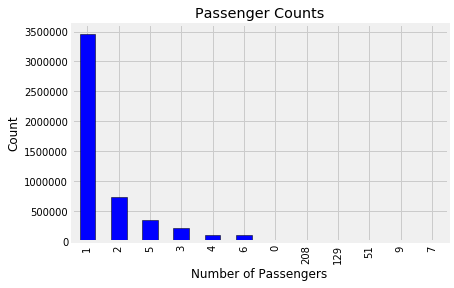

In [8]:
data['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Passenger Counts'); plt.xlabel('Number of Passengers'); plt.ylabel('Count');

Based on this graph, we'll remove any passenger counts greater than 9.

In [9]:
data = data.loc[data['passenger_count'] < 10]

For the `latitude` and `longitude` columns, we can use statistics as well as our intuition for removing outliers. Here I'll find the 2.5% and 97.5% percentile values in each column and keep only measurements close to that range. 

In [10]:
print(f'Initial Observations: {data.shape[0]}')

Initial Observations: 4997767


In [11]:
for col in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']:
    print(f'{col.capitalize():17}: 2.5% = {round(np.percentile(data[col], 2.5), 2)} \t 97.5% = {round(np.percentile(data[col], 97.5), 2)}')

Pickup_latitude  : 2.5% = 40.64 	 97.5% = 40.8
Pickup_longitude : 2.5% = -74.01 	 97.5% = -73.78
Dropoff_latitude : 2.5% = 40.64 	 97.5% = 40.81
Dropoff_longitude: 2.5% = -74.01 	 97.5% = -73.78


Based on these values, we can remove outliers. Here is another potential point for improvement:

* __Potential improvement 2: find a better way to remove outliers.__

In [12]:
# Remove latitude and longtiude outliers
data = data.loc[(data['pickup_latitude'] > 40) & (data['pickup_latitude'] < 42)]
data = data.loc[(data['pickup_longitude'] > -75) & (data['pickup_longitude'] < -72)]
data = data.loc[(data['dropoff_latitude'] > 40) & (data['dropoff_latitude'] < 42)]
data = data.loc[(data['dropoff_longitude'] > -75) & (data['dropoff_longitude'] < -72)]

print(f'New number of observations: {data.shape[0]}')

New number of observations: 4892738


Now we can graph the `latitude` and `longitude` columns to see the distribution. We'll just sample 10000 values so the plot doesn't take too long to generate.

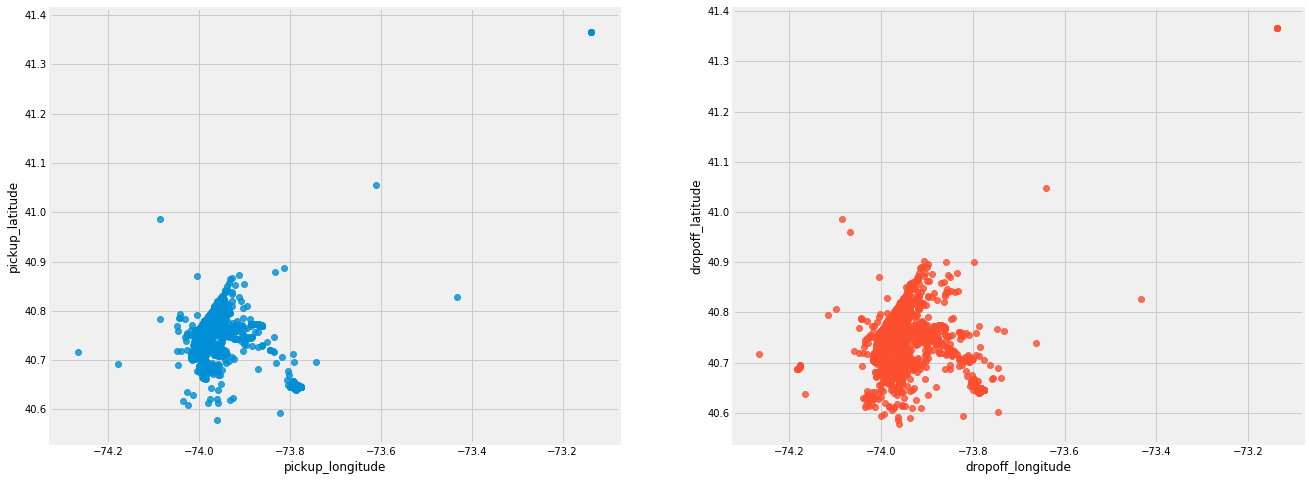

In [13]:
fig, axes = plt.subplots(1, 2, figsize = (20, 8))
axes = axes.flatten()

sns.regplot('pickup_longitude', 'pickup_latitude', fit_reg = False, 
            data = data.sample(10000, random_state = RSEED), ax = axes[0]);
sns.regplot('dropoff_longitude', 'dropoff_latitude', fit_reg = False, 
            data = data.sample(10000, random_state = RSEED), ax = axes[1]);
# axes[1].set_xlim((-75, -73))
# axes[1].set_ylim((-75, -73));

We could plot the pickup and dropoff on top of a map of New York. The following code is taken directly from https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration by Kaggle user [breeman](https://www.kaggle.com/breemen). All credit goes to him and please check out the rest of his kernel for more excellent work! 

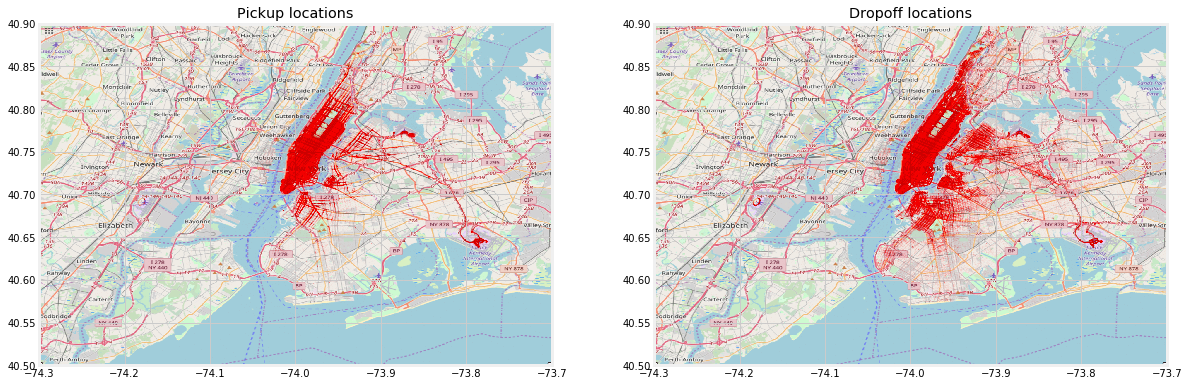

In [14]:
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(18, 16))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)
    
# plot training data on map zoomed in
plot_on_map(data, BB_zoom, nyc_map_zoom, s=0.05, alpha=0.05)

# Feature Engineering

Feature engineering is the process of creating features - predictor variables - out of a dataset. __Feature engineering is the most important step of the machine learning pipeline.__ A model can only learn from the features it is given, and properly constructing features will determine how well your model performs.

As a simple first step of feature engineering, we can find the absolute value of the difference in latitude and longitude between the `pickup` and `dropoff`. While this does not represent an actual distance (we would have to convert coordinate systems), it can be used as a relative comparison of the distances of taxi rides.

In [15]:
# Absolute difference in latitude and longitude
data['abs_lat_diff'] = (data['dropoff_latitude'] - data['pickup_latitude']).abs()
data['abs_lon_diff'] = (data['dropoff_longitude'] - data['pickup_longitude']).abs()

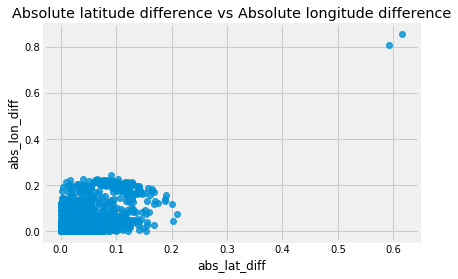

In [16]:
sns.regplot('abs_lat_diff', 'abs_lon_diff', fit_reg = False, data = data.sample(10000, random_state=RSEED));
plt.title('Absolute latitude difference vs Absolute longitude difference');

There do seem to be a few outliers, but I'll leave those in for now. We might also want to take a look if there are any observations where both the absolute differences are 0.

In [17]:
no_diff = data[(data['abs_lat_diff'] == 0) & (data['abs_lon_diff'] == 0)]
no_diff.shape

(51909, 10)

It looks like there are 52,000 rides where the absolute latitude and longitude does not change! That seems a little strange. This might be a point worth following up! 

Let's remake the plot above colored by the fare bin.

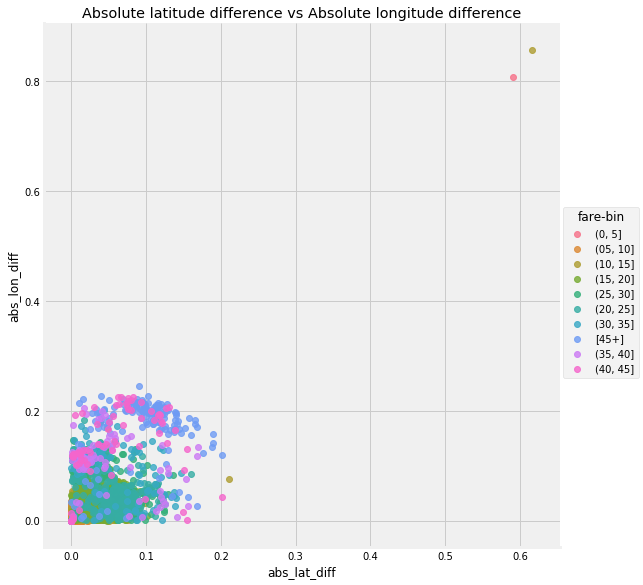

In [18]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', hue = 'fare-bin', size = 8,
           fit_reg = False, data = data.sample(10000, random_state=RSEED));
plt.title('Absolute latitude difference vs Absolute longitude difference');

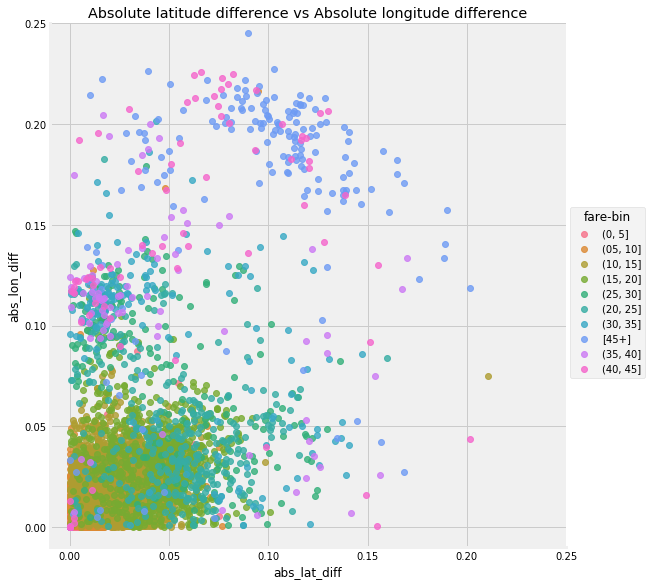

In [19]:
sns.lmplot('abs_lat_diff', 'abs_lon_diff', hue = 'fare-bin', size = 8,
           fit_reg = False, data = data.sample(10000, random_state=RSEED));

plt.xlim((-0.01, .25)); plt.ylim((-0.01, .25))
plt.title('Absolute latitude difference vs Absolute longitude difference');

It does seem that the rides with a larger absolute difference in both longitude and latitude tend to cost more. To capture both differences in a single variable, we can add up the two differences and also find the square root of the sum of distances squared. The former feature would be called the Manhattan distance - or l1 norm - and the latter is called the Euclidean distance - or l2 norm. Both of these distances are specific examples of the general Minkowski distance.

### Minkowski Distance

The [Minkowski Distance](https://en.wikipedia.org/wiki/Minkowski_distance) between two points is expressed as:

$${\displaystyle D\left(X,Y\right)=\left(\sum _{i=1}^{n}|x_{i}-y_{i}|^{p}\right)^{1/p}}$$

if p = 1, then this is the Manhattan distance and if p = 2 this is the Euclidean distance. 

In [20]:
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

Here's an example of the Manhattan Distance which is simply the sum of differences in each dimension.

In [21]:
minkowski_distance(0, 3, 0, 4, 1)

7.0

Here's the same as a Euclidean distance which is the length of a straight line connecting the points.

In [22]:
minkowski_distance(0, 3, 0, 4, 2)

5.0

Let's apply this function to the latitude and longitudes. Again, this does not represent an absolute distance because we would need to convert coordinate systems. However, these features are useful as _relative_ comparisons between rides.

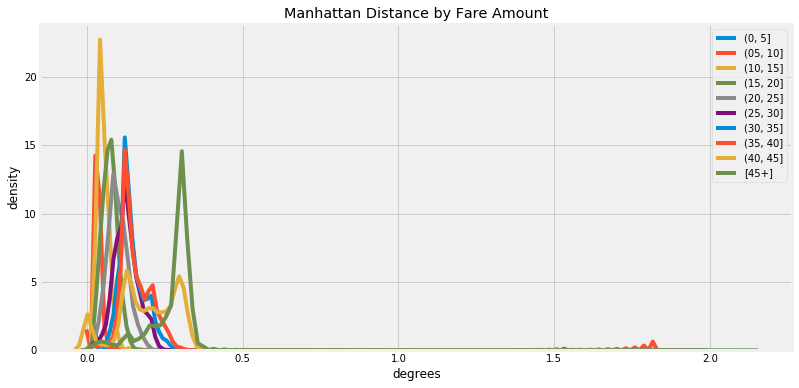

In [23]:
data['manhattan'] = minkowski_distance(data['pickup_longitude'], data['dropoff_longitude'],
                                       data['pickup_latitude'], data['dropoff_latitude'], 1)

# Calculate distribution by each fare bin
plt.figure(figsize = (12, 6))
for f, grouped in data.groupby('fare-bin'):
    sns.kdeplot(grouped['manhattan'], label = f'{f}');

plt.xlabel('degrees'); plt.ylabel('density')
plt.title('Manhattan Distance by Fare Amount');

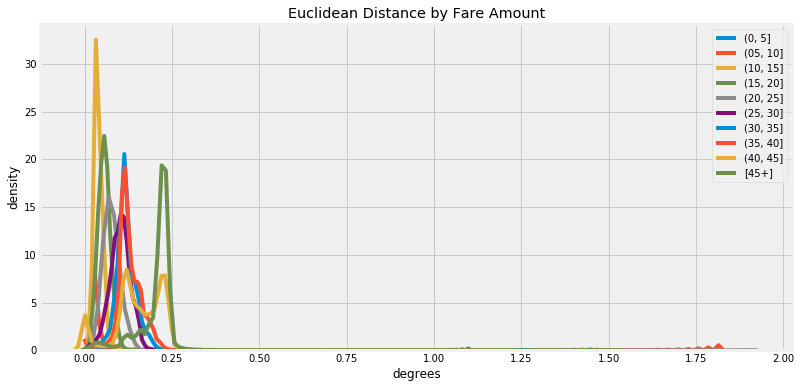

In [24]:
data['euclidean'] = minkowski_distance(data['pickup_longitude'], data['dropoff_longitude'],
                                       data['pickup_latitude'], data['dropoff_latitude'], 2)

# Calculate distribution by each fare bin
plt.figure(figsize = (12, 6))
for f, grouped in data.groupby('fare-bin'):
    sns.kdeplot(grouped['euclidean'], label = f'{f}');

plt.xlabel('degrees'); plt.ylabel('density')
plt.title('Euclidean Distance by Fare Amount');

These features do seem to have some differences between the different fare amounts, so they might be helpful in predicting the fare. 

In [25]:
data.groupby('fare-bin')['euclidean'].agg(['mean', 'count'])

,mean,count
fare-bin,,
"(0, 5]",0.009,760376
"(05, 10]",0.019,2298540
"(10, 15]",0.037,977231
"(15, 20]",0.055,358784
"(20, 25]",0.075,155199
"(25, 30]",0.101,96922
"(30, 35]",0.117,71285
"(35, 40]",0.128,41368
"(40, 45]",0.153,34094


Another plot we can make is the passenger count distribution colored by the fare bin.

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


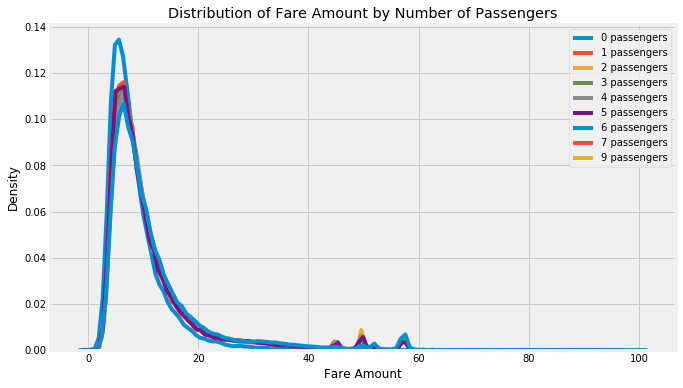

In [26]:
plt.figure(figsize = (10, 6))

for p, grouped in data.groupby('passenger_count'):
    sns.kdeplot(grouped['fare_amount'], label = f'{p} passengers')
    
plt.xlabel('Fare Amount'); plt.ylabel('Density')
plt.title('Distribution of Fare Amount by Number of Passengers');

There does not appear to be much difference between the number of passengers. To get a more accurate picture, we can calculate the actual stats.

In [27]:
data.groupby('passenger_count')['fare_amount'].agg(['mean', 'count'])

,mean,count
passenger_count,,
0,8.937,17216
1,11.141,3383809
2,11.762,723437
3,11.515,214781
4,11.719,103858
5,11.187,346103
6,12.131,103532
7,8.500,1
9,37.040,1


Nope! No real difference in fare between the number of passengers.

## Read in test data and create same features

Before we forget, we need to read in the test data and create the same features. We can't exclude any of the test data based on outliers, and we also shouldn't use the test data for filtering outliers in the training data. The test data should ideally only be used a single time, to test the performance of a trained model.

For the test data, we need to save the `key` column for making submissions. 

In [28]:
test = pd.read_csv('input/test.csv', parse_dates = ['pickup_datetime'])

test['abs_lat_diff'] = (test['dropoff_latitude'] - test['pickup_latitude']).abs()
test['abs_lon_diff'] = (test['dropoff_longitude'] - test['pickup_longitude']).abs()

# Save the id for submission
test_id = list(test.pop('key'))

test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff
count,9914.000,9914.000,9914.000,9914.000,9914.000,9914.000,9914.000
mean,-73.975,40.751,-73.974,40.752,1.671,0.022,0.023
std,0.043,0.034,0.039,0.035,1.279,0.026,0.037
min,-74.252,40.573,-74.263,40.569,1.000,0.000,0.000
25%,-73.993,40.736,-73.991,40.735,1.000,0.007,0.006
50%,-73.982,40.753,-73.980,40.754,1.000,0.015,0.013
75%,-73.968,40.767,-73.964,40.769,2.000,0.028,0.025
max,-72.987,41.710,-72.991,41.697,6.000,0.633,0.849


No fare information here! It's our job to predict the fare for each test ride.

In [29]:
test['manhattan'] = minkowski_distance(test['pickup_longitude'], test['dropoff_longitude'],
                                       test['pickup_latitude'], test['dropoff_latitude'], 1)

test['euclidean'] = minkowski_distance(test['pickup_longitude'], test['dropoff_longitude'],
                                       test['pickup_latitude'], test['dropoff_latitude'], 2)

# Calculate Distance between points using Haversine distance

Another feature engineering step to use is calculating the distance (in km) between the pickup and dropoff using the [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula). This is the distance along a line drawn on the surface of the Earth connecting the two points and takes into account the fact that the Earth is a sphere (or so I'm told). It's not the best measure because the taxis do not travel along lines, but it's probably more accurate than the Manhattan and Euclidean distances made from the absolute latitude and longitude difference. The Manhattan and Euclidean distances are relative and do not take into account the spherical shape of the Earth.

The formula for Haversine distance is:

$${\displaystyle =2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\cos(\varphi _{2})\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$$

where r is the radius of the Earth. The end units will be in km.

In [30]:
# Radius of hte earth in kilometers
R = 6378

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    source: https://stackoverflow.com/a/29546836

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = R * c
    
    return km

In [31]:
data['haversine'] =  haversine_np(data['pickup_longitude'], data['pickup_latitude'],
                         data['dropoff_longitude'], data['dropoff_latitude']) 

test['haversine'] = haversine_np(test['pickup_longitude'], test['pickup_latitude'],
                         test['dropoff_longitude'], test['dropoff_latitude'])

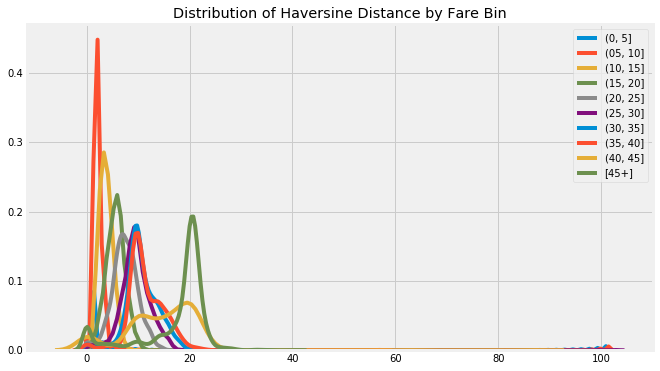

In [32]:
subset = data.sample(100000, random_state=RSEED)

plt.figure(figsize = (10, 6))

for f, grouped_data in subset.groupby('fare-bin'):
    sns.kdeplot(grouped_data['haversine'], label = f'{f}')
    
plt.title('Distribution of Haversine Distance by Fare Bin');

It does seem there is a significant difference here! The larger haversine distances tend to have larger fares as expected.

In [33]:
data.groupby('fare-bin')['haversine'].agg(['mean', 'count'])

,mean,count
fare-bin,,
"(0, 5]",0.911,760376
"(05, 10]",1.931,2298540
"(10, 15]",3.695,977231
"(15, 20]",5.565,358784
"(20, 25]",7.510,155199
"(25, 30]",9.502,96922
"(30, 35]",10.719,71285
"(35, 40]",11.615,41368
"(40, 45]",13.933,34094


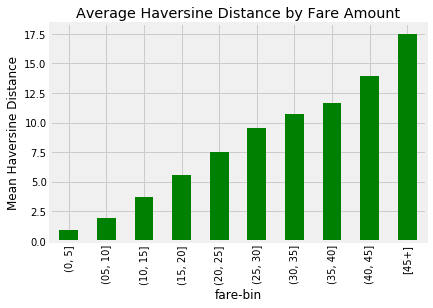

In [34]:
data.groupby('fare-bin')['haversine'].mean().sort_index().plot.bar(color = 'g');
plt.title('Average Haversine Distance by Fare Amount');
plt.ylabel('Mean Haversine Distance');

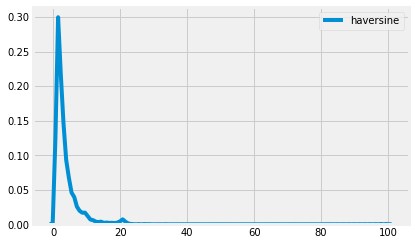

In [35]:
sns.kdeplot(test['haversine']);

The test distribution seems to be similar to the training distribution.

# Machine Learning

Now that we have built a few potentially useful features, we can use them for machine learning: training an algorithm to predict the target from the features. We'll start off with a basic model only using a few features and then move on to more complex models with more features.

## First Model: Linear Regression

The first model we'll make is a simple linear regression using 3 features: the `abs_lat_diff`, `abs_lon_diff`, and `passenger_count`. This is meant to serve as a baseline for us to beat.

It's good to start with a simple model because it will give you a baseline. Also, if a simple model works well enough, then there may be no need for more complex models. If a linear regression will get the job done, then you don't need a neural network!

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lr = LinearRegression()

## Create Training and Validation Set

We'll want to create a training and separate validation set to assess our model. Ideally, we only use the test set once, to evaluate the final model. We can a the validation set with 1 million observations to estimate our performance.

We __stratify__ the split using the `fare-bin`. This ensures that the training and validation set have the same distribution of fare bins. This is important for imbalanced classification problems, but it can also be useful for regression problems so we don't end up with a lot of outliers in terms of the target in either the validation or training set.

In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      stratify = data['fare-bin'],
                                                      random_state = RSEED, test_size = 1_000_000)

### Train with Simple Features

We can train the linear regression using three features. The benefit of the linear regression is that it's interpretable: we can inspect the coefficients and intercept.

In [38]:
lr.fit(X_train[['abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

print('Intercept', round(lr.intercept_, 4))
print('abs_lat_diff coef: ', round(lr.coef_[0], 4), 
      'abs_lon_diff coef:', round(lr.coef_[1], 4),
      'passenger_count coef:', round(lr.coef_[2], 4))

Intercept 4.9982
abs_lat_diff coef:  114.8335 abs_lon_diff coef: 164.8356 passenger_count coef: 0.0501


In all cases, the coefficient is positive, indicating a larger value of the variable corresponds to a larger fare according to the model. The `intercept` indicates the fare that would be predicted if there is no latitude or longitude difference and the passenger count is 0.

#### Score Model

Here we use the validation set for assessing the model. We'll use two metrics:

* __Root mean squared error__: the metric used by the competition
* __Mean absolute percentage error__: the average percentage error of the predictions

I like using the mean absolute percentage error (MAPE) because it's often more interpretable. 

In [39]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

In [40]:
evaluate(lr, ['abs_lat_diff', 'abs_lon_diff', 'passenger_count'], 
        X_train, X_valid, y_train, y_valid)

Training:   rmse = 5.31 	 mape = 28.6
Validation: rmse = 5.4 	 mape = 28.74


### Naive Baseline

To make sure that machine learning is even applicable to the task, we should compare these predictions to a naive guess. For a regression task, this can be as simple as the average value of the target in the training data.

In [41]:
train_mean = y_train.mean()
train_preds = [train_mean for _ in range(len(y_train))]
valid_preds = [train_mean for _ in range(len(y_valid))]

tr, vr, tm, vm = metrics(train_preds, valid_preds, y_train, y_valid)

print(f'Baseline Training:   rmse = {round(tr, 2)} \t mape = {round(tm, 2)}')
print(f'Baseline Validation: rmse = {round(vr, 2)} \t mape = {round(vm, 2)}')

Baseline Training:   rmse = 9.36 	 mape = 65.8
Baseline Validation: rmse = 9.36 	 mape = 65.67


According to the naive baseline, our machine learning solution is effective! We are able to reduce the percentage error by about half and generate much better predictions than using no machine learning. This should give us confidence we are on the right track.

### Make a submission

In order to make a submission to Kaggle, we have to make predictions on the test data. Below we make the predictions and save them to a csv file in the format specified by the competition

In [42]:
preds = lr.predict(test[['abs_lat_diff', 'abs_lon_diff', 'passenger_count']])

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_lr_simple.csv', index = False)

As a sanity check, we can plot the predictions.

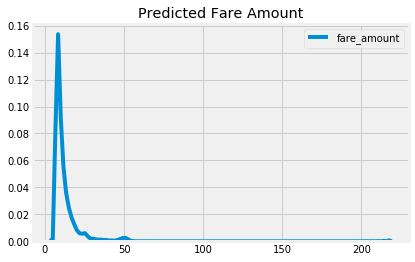

In [43]:
sns.kdeplot(sub['fare_amount'])
plt.title('Predicted Fare Amount');

The predicted distribution appears reasonable. Because the competition uses root mean squared error as the metric, any predictions that are far off will have an outsized effect on the error. Let's look at predictions that were greater than \$100.

In [44]:
test.loc[sub[sub['fare_amount'] > 100].index]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,manhattan,euclidean,haversine
4080,2010-06-11 13:37:21 UTC,-73.137,41.366,-73.984,40.733,1,0.633,0.847,1.480,1.057,100.106
5887,2010-07-04 16:44:11 UTC,-73.137,41.366,-73.983,40.767,1,0.599,0.845,1.444,1.036,97.348
8529,2009-11-25 19:32:52 UTC,-73.137,41.366,-73.987,40.758,3,0.608,0.849,1.457,1.044,98.300


In [45]:
sub[sub['fare_amount'] > 100]

,key,fare_amount
4080,2010-06-11 13:37:21.0000004,217.337
5887,2010-07-04 16:44:11.0000002,213.147
8529,2009-11-25 19:32:52.0000001,214.960


These three predictions that are all over \$100 don't appear to be completely shocking given the `abs_lat_diff` and `abs_lon_diff`. We'll have to take a look at these predictions for other models and see if they agree. 

In [46]:
simple_over_100 = list(sub[sub['fare_amount'] > 100].index)
sub['fare_amount'].describe()

count   9914.000
mean      11.472
std        8.166
min        5.048
25%        7.432
50%        9.083
75%       12.349
max      217.337
Name: fare_amount, dtype: float64

## Use More Features

While the first model scored well relative to the baseline, there is much room for improvement. As a first step, let's use one of the other features we created, the `haversine` distance.

In [47]:
lr.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

evaluate(lr, ['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'], 
         X_train, X_valid, y_train, y_valid)

Training:   rmse = 5.0 	 mape = 25.15
Validation: rmse = 5.07 	 mape = 25.22


In [48]:
print(lr.intercept_)
print(lr.coef_)

4.495708046916876
[ 4.23194822e+00 -2.38121835e+02 -1.01178168e+02  4.46978579e-02]


Using this one more feature improved our score slightly. Here's another chance for improvement using the same model:

* __Potential Improvement 3: find the optimal set of features using the simple linear regression model__

One thing we do want to be careful about is highly correlated, known as collinear features. These can decrease the generalization performance of the model and lead to less interpretable models. Many of our features are already highly correlated as shown in the heatmap below. This plots the Pearson Correlation Coefficient for each pair of variables.

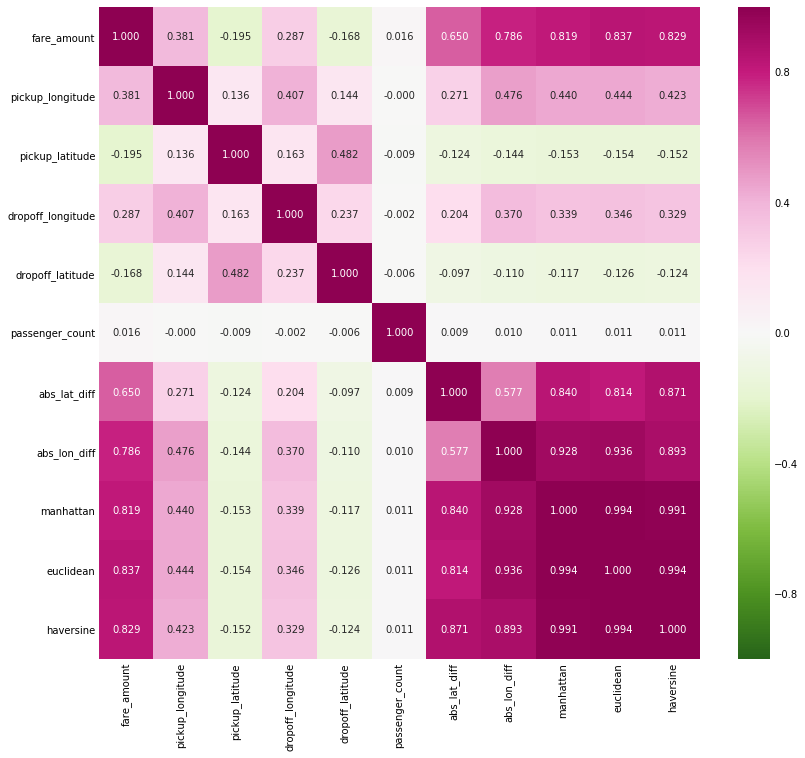

In [49]:
corrs = data.corr()

plt.figure(figsize = (12, 12))
sns.heatmap(corrs, annot = True, vmin = -1, vmax = 1, fmt = '.3f', cmap=plt.cm.PiYG_r);

# Upgraded Model

When we want to improve performance, we generally have a few options:

1. Get more data - either more observations or more variables
2. Engineer more / better features
3. Perform feature selection to remove irrelevant features
4. Try a more complex model
5. Perform hyperparameter tuning of the selected model

We already saw that including another feature could improve perfomance. For now let's move past the features and focus on the model (we'll come back to features later).

The simple linear regression has no hyperparameters to optimize (no settings to tune) so we'll try approach 4. If the more complex model does well, we can use it for testing additional features or performing feature selection

## Use Non-Linear Model

For a first non-linear model, we'll use the Random Forest regressor. This is a powerful ensemble of regression trees that has good performance and generalization ability because of its low variance. We'll use most of the default hyperparameters but change the `n_estimators` and the `max_depth` of each tree in the forest. For the features, we'll use the four features which delivered good performance in the linear regression.

In [50]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest
random_forest = RandomForestRegressor(n_estimators = 25, max_depth = 25, 
                                      max_features = None, oob_score = True, 
                                      bootstrap = True, verbose = 1, n_jobs = -1)

# Train on data
random_forest.fit(X_train[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']], y_train)

[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:  1.0min remaining:   15.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.1min finished
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
           oob_score=True, random_state=None, verbose=1, warm_start=False)

In [51]:
evaluate(random_forest, ['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count'],
         X_train, X_valid, y_train, y_valid)

[Parallel(n_jobs=16)]: Done  20 out of  25 | elapsed:    5.3s remaining:    1.3s
[Parallel(n_jobs=16)]: Done  25 out of  25 | elapsed:    5.6s finished


Training:   rmse = 3.1 	 mape = 19.02
Validation: rmse = 4.27 	 mape = 23.32


[Parallel(n_jobs=16)]: Done  20 out of  25 | elapsed:    1.4s remaining:    0.3s
[Parallel(n_jobs=16)]: Done  25 out of  25 | elapsed:    1.5s finished


The random forest does much better than the simple linear regression. This indicates that the problem is probably not linear, or at least is not linear in terms of the features we have constructed. From here going forward, we'll use the same random forest model because of the increased performance. 

#### Overfitting

Given the gap between the training and the validation score, we can see that our model is __overfitting__ to the training. This is one of the most common problems in machine learning and is usually addressed either by training with more data, or adjusting the hyperparameters of the model. This leads to another recommendation for improvement:

* __Potential Improvement 4: Try searching for better random forest model hyperparameters__. You may find Scikit-Learn's `RandomizedSearchCV` a useful tool.

Next we can make predictions with the random forest for uploading to the competition.

[Parallel(n_jobs=16)]: Done  20 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  25 out of  25 | elapsed:    0.0s finished
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


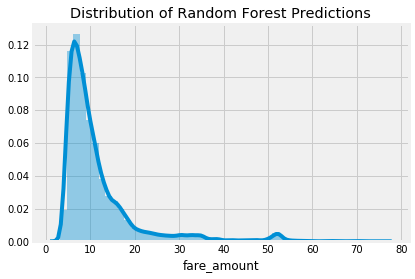

In [52]:
preds = random_forest.predict(test[['haversine', 'abs_lat_diff', 'abs_lon_diff', 'passenger_count']])

sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
sub.to_csv('sub_rf_simple.csv', index = False)

sns.distplot(sub['fare_amount'])
plt.title('Distribution of Random Forest Predictions');

This time we don't see any extreme predictions as we saw with the first linear regression. The random forest tends to not produce outlying predictions because the voting of the trees means that any single tree that estimates an extreme value will be tempered by the other predictions. 

Let's look at the 3 predictions the original simple linear regression estimated as over \$100.

In [53]:
sub.loc[simple_over_100]

,key,fare_amount
4080,2010-06-11 13:37:21.0000004,8.993
5887,2010-07-04 16:44:11.0000002,7.284
8529,2009-11-25 19:32:52.0000001,22.216


# More Features

Now that we've decided on the Random Forest as our model, we can try using additional features. Let's see what happens when we use 8 of the features for training. 

In [54]:
def model_rf(X_train, X_valid, y_train, y_valid, test, features,
             model = RandomForestRegressor(n_estimators = 25, max_depth = 25,
                                           n_jobs = -1)):
    
    # Train
    model.fit(X_train[features], y_train)
    
    # Validation
    evaluate(model, features, X_train, X_valid, y_train, y_valid)
    
    # Make predictions on test and generate submission dataframe
    preds = model.predict(test[features])
    sub = pd.DataFrame({'key': test_id, 'fare_amount': preds})
    
    # Extract feature importances
    feature_importances = pd.DataFrame({'feature': features,
                                        'importance': model.feature_importances_}).\
                           sort_values('importance', ascending = False)
    
    return sub, feature_importances

In [55]:
data.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'fare-bin',
       'abs_lat_diff', 'abs_lon_diff', 'manhattan', 'euclidean', 'haversine'],
      dtype='object')

In [56]:
# Evaluate using 8 features
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 'passenger_count',
                               'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])

Training:   rmse = 2.55 	 mape = 16.52
Validation: rmse = 3.75 	 mape = 20.7


It appears that using more features helps the model! We can look at the feature importances to see which the model considers "most relevant"

In [57]:
fi

,feature,importance
2,haversine,0.837
7,dropoff_longitude,0.041
1,abs_lon_diff,0.035
5,pickup_longitude,0.024
6,dropoff_latitude,0.023
4,pickup_latitude,0.020
0,abs_lat_diff,0.016
3,passenger_count,0.003


The `haversine` distance is by far the most important with the other features showing considerably less relevance to the model. This suggests that distance is key, and we might want to find a more accurate way of calculating distances.

In [58]:
sub.to_csv('sub_rf_8_features.csv', index = False)

# Additional Feature Engineering

We saw that adding more features improves the performance of the model. A natural progression is therefore to use even more features! We have not made any use of the `pickup_datetime` which provides the precise moment of pickup and that's where we'll turn our attention to next. 

## Extract Datetime Information

We can write a simple function that extracts as much date and time information from a datetime as possible. This is adapted from the excellent fast.ai library, in particular, the structured module (available at https://github.com/fastai/fastai/blob/master/fastai/structured.py). I have made a few changes based on what's worked best for me in the past on time-series problems.

This function calculates a number of expected attributes:

* Year
* Month
* Day
* Day of Year
* Day of Week

When we have a time, additional variables can be calculated:

* Hour 
* Minute 
* Second

Pandas also offers options for some more complex attributes like:

* Is_month_end  
* Is_month_start
* Is_quarter_end
* Is_quarter_start
* Is_year_end
* Is_year_start

These are more intended for financial analysis, but they may come in handy in other problems. For now, I have decided not to use these attributes.

### Fractional Time Variables

Finally, I add a number of other calculations that combine existing measures to create fractional variables:

* Fractional time of day
* Fractional time of week
* Fractional time of month
* Fractional time of year

These are all measured from 0 - 1 in units of whichever time period we are measuring on. The idea behind these variables is that they can take the place of several other time indicators. For example, instead of using the `Dayof week`, `Hour`, `Minute`, and `Second`, we can use the fractional time of the week to find out precisely when the observation takes place in the week.

I have found that the fractional time variables work well in practice especially with non-linear models. When we use linear models, a good approach is [cyclical variable encoding](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/) of time features, but I haven't found this to be necessary with non-linear models.

In [61]:
import re

def extract_dateinfo(df, date_col, drop=True, time=False, 
                     start_ref = pd.datetime(1900, 1, 1),
                     extra_attr = False):
    """
    Extract Date Information from a DataFrame
    Adapted from: https://github.com/fastai/fastai/blob/master/fastai/structured.py
    """
    df = df.copy()
    
    # Extract the field
    fld = df[date_col]
    
    # Check the time
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    # Convert to datetime if not already
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[date_col] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    

    # Prefix for new columns
    pre = re.sub('[Dd]ate', '', date_col)
    pre = re.sub('[Tt]ime', '', pre)
    
    # Basic attributes
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Days_in_month', 'is_leap_year']
    
    # Additional attributes
    if extra_attr:
        attr = attr + ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 
                       'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    # If time is specified, extract time information
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second']
        
    # Iterate through each attribute
    for n in attr: 
        df[pre + n] = getattr(fld.dt, n.lower())
        
    # Calculate days in year
    df[pre + 'Days_in_year'] = df[pre + 'is_leap_year'] + 365
        
    if time:
        # Add fractional time of day (0 - 1) units of day
        df[pre + 'frac_day'] = ((df[pre + 'Hour']) + (df[pre + 'Minute'] / 60) + (df[pre + 'Second'] / 60 / 60)) / 24
        
        # Add fractional time of week (0 - 1) units of week
        df[pre + 'frac_week'] = (df[pre + 'Dayofweek'] + df[pre + 'frac_day']) / 7
    
        # Add fractional time of month (0 - 1) units of month
        df[pre + 'frac_month'] = (df[pre + 'Day'] + (df[pre + 'frac_day'])) / (df[pre + 'Days_in_month'] +  1)
        
        # Add fractional time of year (0 - 1) units of year
        df[pre + 'frac_year'] = (df[pre + 'Dayofyear'] + df[pre + 'frac_day']) / (df[pre + 'Days_in_year'] + 1)
        
    # Add seconds since start of reference
    df[pre + 'Elapsed'] = (fld - start_ref).dt.total_seconds()
    
    if drop: 
        df = df.drop(date_col, axis=1)
        
    return df

In [62]:
print(data['pickup_datetime'].min())
print(test['pickup_datetime'].min())

In [63]:
test = extract_dateinfo(test, 'pickup_datetime', drop = False, 
                         time = True, start_ref = data['pickup_datetime'].min())
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,manhattan,euclidean,...,pickup_is_leap_year,pickup_Hour,pickup_Minute,pickup_Second,pickup_Days_in_year,pickup_frac_day,pickup_frac_week,pickup_frac_month,pickup_frac_year,pickup_Elapsed
0,2015-01-27 13:08:24,-73.973,40.764,-73.981,40.744,1,0.020,0.008,0.028,0.022,...,False,13,8,24,365,0.547,0.221,0.861,0.075,191596058.000
1,2015-01-27 13:08:24,-73.987,40.719,-73.999,40.739,1,0.020,0.012,0.032,0.023,...,False,13,8,24,365,0.547,0.221,0.861,0.075,191596058.000
2,2011-10-08 11:53:44,-73.983,40.751,-73.980,40.746,1,0.005,0.003,0.008,0.006,...,False,11,53,44,365,0.496,0.785,0.265,0.769,87306778.000
3,2012-12-01 21:12:12,-73.981,40.768,-73.990,40.752,1,0.016,0.009,0.025,0.019,...,True,21,12,12,366,0.883,0.840,0.059,0.918,123628286.000
4,2012-12-01 21:12:12,-73.966,40.790,-73.989,40.744,1,0.045,0.023,0.068,0.051,...,True,21,12,12,366,0.883,0.840,0.059,0.918,123628286.000


In [64]:
data = extract_dateinfo(data, 'pickup_datetime', drop = False, 
                         time = True, start_ref = data['pickup_datetime'].min())
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,abs_lat_diff,abs_lon_diff,...,pickup_is_leap_year,pickup_Hour,pickup_Minute,pickup_Second,pickup_Days_in_year,pickup_frac_day,pickup_frac_week,pickup_frac_month,pickup_frac_year,pickup_Elapsed
0,4.500,2009-06-15 17:26:21,-73.844,40.721,-73.842,40.712,1,"(0, 5]",0.009,0.003,...,False,17,26,21,365,0.727,0.104,0.507,0.456,14318735.000
1,16.900,2010-01-05 16:52:16,-74.016,40.711,-73.979,40.782,1,"(15, 20]",0.071,0.037,...,False,16,52,16,365,0.703,0.243,0.178,0.016,31942290.000
2,5.700,2011-08-18 00:35:00,-73.983,40.761,-73.991,40.751,2,"(05, 10]",0.011,0.009,...,False,0,35,0,365,0.024,0.432,0.563,0.628,82859654.000
3,7.700,2012-04-21 04:30:42,-73.987,40.733,-73.992,40.758,1,"(05, 10]",0.025,0.004,...,True,4,30,42,366,0.188,0.741,0.683,0.306,104214596.000
4,5.300,2010-03-09 07:51:00,-73.968,40.768,-73.957,40.784,1,"(05, 10]",0.016,0.011,...,False,7,51,0,365,0.327,0.190,0.291,0.187,37353014.000


## Explore Time Variables

We now have a ton of time-variables to explore! First, let's ask the question if fares have increased over time. To do this, we can plot the `time_elapsed` versus the fare.

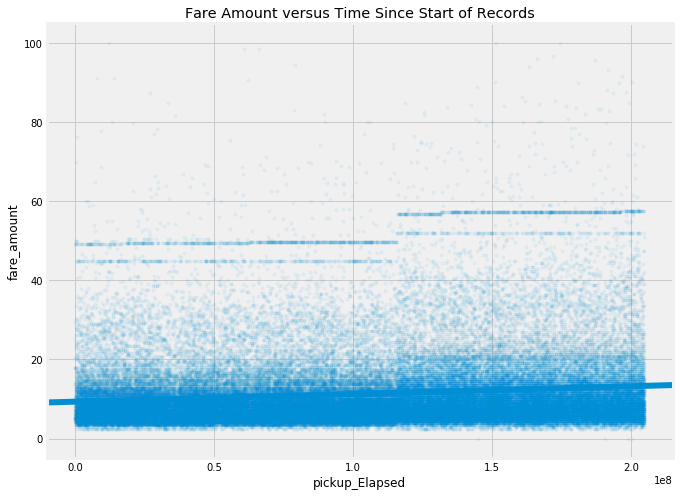

In [65]:
plt.figure(figsize = (10, 8))
sns.regplot('pickup_Elapsed', 'fare_amount', scatter_kws= {'alpha': 0.05}, marker = '.',
           data = data.sample(100000, random_state=RSEED));
plt.title('Fare Amount versus Time Since Start of Records');

There appears to be a minor increase in prices over time which might be expected taking into account inflation. Let's look at the average fare amount by the hour of day.

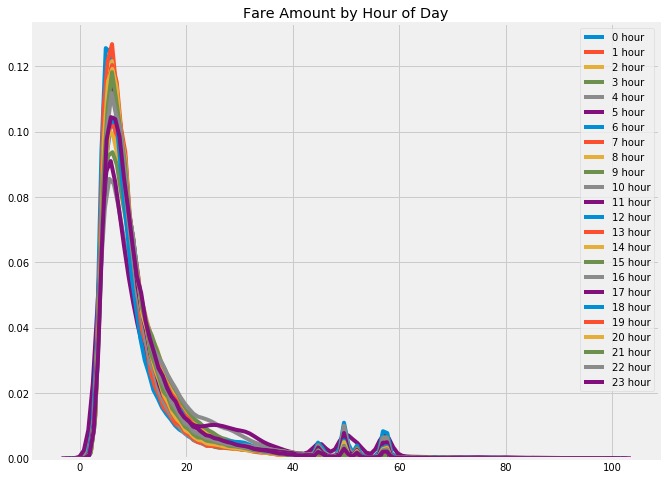

In [66]:
plt.figure(figsize = (10, 8))
for h, grouped in data.groupby('pickup_Hour'):
    sns.kdeplot(grouped['fare_amount'], label = f'{h} hour')
plt.title('Fare Amount by Hour of Day');

We can make the same plot by day of the week.

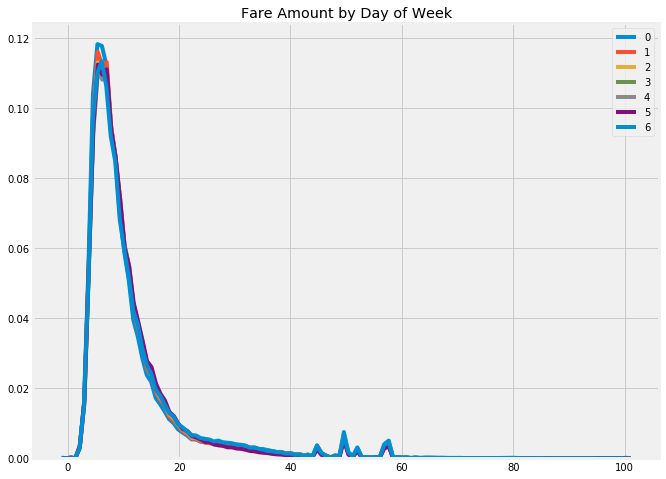

In [67]:
plt.figure(figsize = (10, 8))
for d, grouped in data.groupby('pickup_Dayofweek'):
    sns.kdeplot(grouped['fare_amount'], label = f'{d}')
plt.title('Fare Amount by Day of Week');

Both of these plots do not seem to show much difference between the different times. 

### Fractional Time Plots

As a final exploration of the time variables, we can plot the fare amount versus the fractional time. 

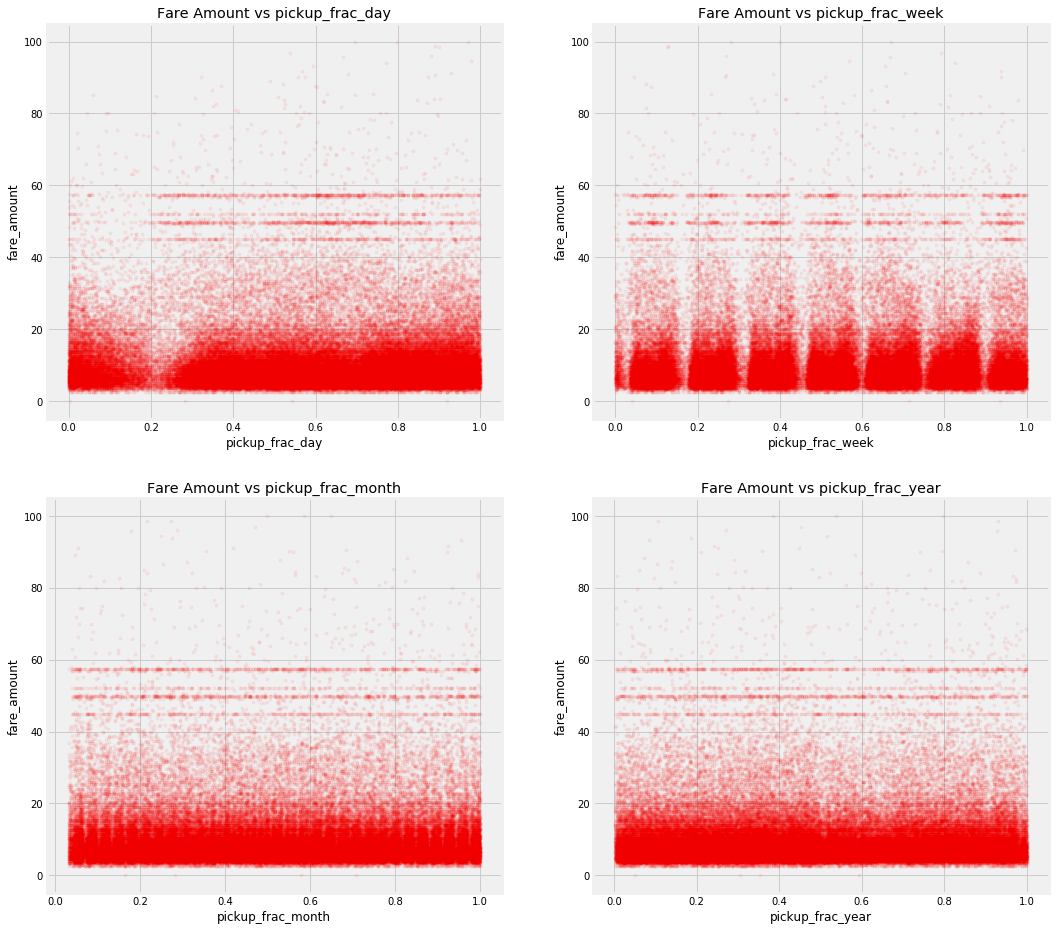

In [68]:
fig, axes = plt.subplots(2, 2, figsize = (16, 16))
axes = axes.flatten()

# Plot each of the fractional times
for i, d in enumerate(['day', 'week', 'month', 'year']):
    ax = axes[i]
    sns.regplot(f'pickup_frac_{d}', 'fare_amount', 
                data = data.sample(100000, random_state = RSEED), 
                fit_reg = False, scatter_kws = {'alpha': 0.05}, marker = '.', ax = ax,
                color = 'r')
    
    ax.set_title(f'Fare Amount vs pickup_frac_{d}')

None of these graphs are very decisive. One interesting thing to note is the horizontal bars at different fare amounts. This suggests there may be certain routes that always have the same fare amount. We explored the fare distribution earlier, but it might be a good idea to revisit the abnormalities in the fares.

In [69]:
fare_counts = data.groupby('fare_amount')['haversine'].agg(['count', pd.Series.nunique]).sort_values('count', ascending = False)
fare_counts.head()

,count,nunique
fare_amount,,
6.500,238197,235802.000
4.500,201277,198253.000
8.500,183757,182267.000
5.700,143214,141424.000
5.300,143188,141222.000


There are a number of very common fares. These could indicate certain rides that are a set amount. This brings up another area for improvement: 

* __Potential improvement 5: find out what the same amount fares have in common.__ See if this can be used to determine if there are standard fares, and what these rides are which could be used for modeling. 

### Test Time Features

Now we can use the time features in our model to see if they yield any improvement. We'll need to resplit the data (using the same random state).

In [70]:
X_train, X_valid, y_train, y_valid = train_test_split(data, np.array(data['fare_amount']), 
                                                      stratify = data['fare-bin'],
                                                      random_state = RSEED, test_size = 1_000_000)

For the time features, we'll use the fractional measurements as well as the time elapsed since the beginning of the records. We'll keep the same features as the previous training run except remove the passenger count since it was the lowest importance feature in the random forest. (This gives us a total of 12 features).

In [71]:
time_features = ['pickup_frac_day', 'pickup_frac_week', 'pickup_frac_month', 'pickup_frac_year',
                 'pickup_Elapsed']

features = ['abs_lat_diff', 'abs_lon_diff', 'haversine', 
            'pickup_latitude', 'pickup_longitude', 
            'dropoff_latitude', 'dropoff_longitude'] + time_features

In [72]:
# Test using the 7 features and the time features
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = features)

Training:   rmse = 2.1 	 mape = 13.41
Validation: rmse = 3.38 	 mape = 17.92


Just for comparison, we can go back to the linear regression and look at the performance.

In [73]:
lr = LinearRegression()

# Fit and evaluate
lr.fit(X_train[features], y_train)
evaluate(lr, features, X_train, X_valid, y_train, y_valid)

Training:   rmse = 4.85 	 mape = 24.51
Validation: rmse = 4.91 	 mape = 24.62


It seems that the new features helped both the random forest and the linear regression. Let's take a look at the random forest feature importances.

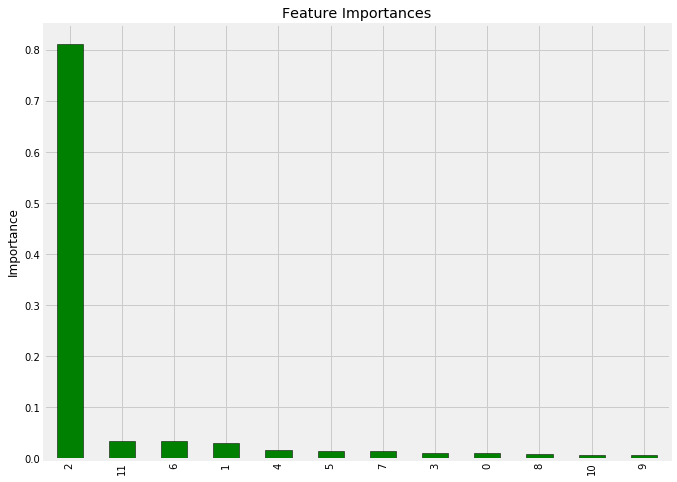

In [74]:
# fi.set_index('feature', inplace = True)
plt.figure(figsize = (10, 8))
fi['importance'].plot.bar(color = 'g', edgecolor = 'k');
plt.ylabel('Importance'); plt.title('Feature Importances');

Once again, the `haversine` distance dominates the importance. The time elapsed since the first record seems to be relatively important although the other time features do not seem to be of much use. 

In [75]:
# Save submission
sub.to_csv('sub_rf_frac_time.csv', index = False)

## Try with All Time Variables

For a final submission, we'll use every single one of the features. This probably will lead to overfitting, but let's test it out.

In [76]:
features = list(data.columns)

for f in ['pickup_datetime', 'fare_amount', 'fare-bin']:
    features.remove(f)
    
len(features)

27

In [77]:
# Test using the 7 features and the time features
sub, fi = model_rf(X_train, X_valid, y_train, y_valid, test, 
                   features = features)

Training:   rmse = 2.07 	 mape = 13.53
Validation: rmse = 3.39 	 mape = 18.0


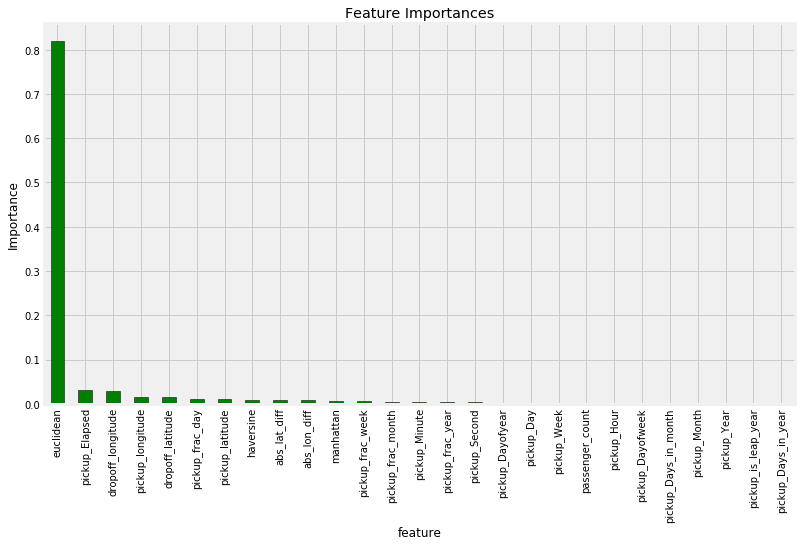

In [78]:
fi.set_index('feature', inplace = True)
plt.figure(figsize = (12, 7))
fi['importance'].plot.bar(color = 'g', edgecolor = 'k');
plt.ylabel('Importance'); plt.title('Feature Importances');

In [79]:
sub.to_csv('sub_rf_all_features.csv', index = False)

## Better Model

Although the random forest has high performance, it does not always work the best for every problem. There are still more models to try:

* __Potential improvement 6: try more models.__ You might find the Gradient Boosting Machine or Deep Neural Networks to be capable learners.

# Your Challenge

From here, we can still engineer more features or we can try upgrading the model. At this point, I'm going to leave it up to you! I've given you a decent start and some recommendations for improvement so I'll leave you here. I'm working on some more notebooks with additional performance gains, but see if you can take these methods and improve! To wrap up, here are my recommendations:

1. Train with more data
2. Find a better way for filtering outliers
3. Find an optimal set of features
4. Hyperparameter tuning of the random forest
5. Use domain knowledge to figure out if there are standard fares or what the same fares have in common
6. Try more complex models

I have to add that these are all __potential__ improvements because of course we don't know if they will work until we try! I wish you the best of luck, and I'll be back in another kernel with some improvements of my own. 

Best,

Will

In [80]:
data_rounded = data.round(2).groupby(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])['fare_amount'].count().reset_index().drop(columns = 'fare_amount')
data_rounded.to_csv('input/data_rounded.csv', index = False)
print(data_rounded.shape)

test_rounded = test.round(2).groupby(['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'])['haversine'].count().reset_index().drop(columns = 'haversine')
test_rounded.to_csv('input/test_rounded.csv', index = False)
print(test_rounded.shape)

(62886, 4)
(2995, 4)
